In [ ]:
!pip install youtokentome rouge razdel

In [0]:
import os
import youtokentome as yttm
import razdel
import random
import math
import copy
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import Counter
from typing import List, Tuple
from rouge import Rouge
from nltk.translate.bleu_score import corpus_bleu
from torch.utils import data

In [6]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
cleaned_dataset = pd.read_json('/content/drive/My Drive/cleaned_dataset.json')

Split data to train, val and test sets.

In [0]:
import sklearn.utils
temp = cleaned_dataset[:]
temp = sklearn.utils.shuffle(temp)

train_records = temp[:100000]
val_records = temp[100000:116000]
test_records = temp[116000:]

Utils: score calculating

In [0]:
def calc_scores(references, predictions, metric="all"):
    print("Count:", len(predictions))
    print("Last true headline:", references[-1])
    print("Last predicted headline:", predictions[-1])

    if metric in ("bleu", "all"):
        print("\nBLEU: ", corpus_bleu([[r] for r in references], predictions))
    if metric in ("rouge", "all"):
        rouge = Rouge()
        scores = rouge.get_scores(predictions, references, avg=True)
        scores_string = ""
        for metric, value in scores.items():
            scores_string += "\n" + str(metric) + ":" + str(value)
        print("ROUGE: ", scores_string, "\n")

Byte Pair Encoding (BPE)

In [0]:
def train_bpe(records, model_path, model_type="bpe", vocab_size=30000, lower=True):
    temp_file_name = "temp.txt"
    with open(temp_file_name, "w") as temp:
        for text, title in tqdm(records[['Text', 'Head_title']].values):
            if lower:
                title = title.lower()
                text = text.lower()
            if not text or not title:
                continue
            temp.write(text + "\n")
            temp.write(title + "\n")
    yttm.BPE.train(data=temp_file_name, vocab_size=vocab_size, model=model_path)

In [11]:
train_bpe(train_records, "BPE_model.bin")

100%|██████████| 100000/100000 [00:02<00:00, 43841.33it/s]


In [12]:
bpe_processor = yttm.BPE('BPE_model.bin')
bpe_processor.encode(["шустрая бурая лиса прыгает через ленивого пса"], output_type=yttm.OutputType.SUBWORD)

[['▁шу',
  'страя',
  '▁бу',
  'рая',
  '▁ли',
  'са',
  '▁пры',
  'гает',
  '▁через',
  '▁лени',
  'вого',
  '▁п',
  'са']]

Collect vocabulary token indexation.

In [0]:
class Vocabulary:
    def __init__(self, bpe_processor):
        self.index2word = bpe_processor.vocab()
        self.word2index = {w: i for i, w in enumerate(self.index2word)}
        self.word2count = Counter()

    def get_pad(self):
        return self.word2index["<PAD>"]

    def get_sos(self):
        return self.word2index["<SOS>"]

    def get_eos(self):
        return self.word2index["<EOS>"]

    def get_unk(self):
        return self.word2index["<UNK>"]
    
    def has_word(self, word) -> bool:
        return word in self.word2index

    def get_index(self, word):
        if word in self.word2index:
            return self.word2index[word]
        return self.get_unk()

    def get_word(self, index):
        return self.index2word[index]

    def size(self):
        return len(self.index2word)

    def is_empty(self):
        empty_size = 4
        return self.size() <= empty_size

    def reset(self):
        self.word2count = Counter()
        self.index2word = ["<pad>", "<sos>", "<eos>", "<unk>"]
        self.word2index = {word: index for index, word in enumerate(self.index2word)}

In [14]:
vocabulary = Vocabulary(bpe_processor)
vocabulary.size()

30000

Oracle summary cache.

In [0]:
def add_oracle_summary_to_records(records, max_sentences=30, lower=True, nrows=1000):
    rouge = Rouge()
    sentences_ = []
    oracle_sentences_ = []
    oracle_summary_ = []
    records = records.iloc[:nrows].copy()

    for text, title in tqdm(records[['Text', 'Head_title']].values):
        title = title.lower() if lower else title
        sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
        oracle_summary, sentences_indicies = build_oracle_summary_greedy(text, title, calc_score=lambda x, y: calc_single_score(x, y, rouge),
                                                                         lower=lower, max_sentences=max_sentences)
        sentences_ += [sentences]
        oracle_sentences_ += [list(sentences_indicies)]
        oracle_summary_ += [oracle_summary]
    records['sentences'] = sentences_
    records['oracle_sentences'] = oracle_sentences_
    records['oracle_summary'] = oracle_summary_
    return records


def build_oracle_summary_greedy(text, gold_summary, calc_score, lower=True, max_sentences=30):
    gold_summary = gold_summary.lower() if lower else gold_summary
    # Split to the sentences
    sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
    n_sentences = len(sentences)
    oracle_summary_sentences = set()
    score = -1.0
    summaries = []
    for _ in range(min(n_sentences, 2)):
        for i in range(n_sentences):
            if i in oracle_summary_sentences:
                continue
            current_summary_sentences = copy.copy(oracle_summary_sentences)
            # Add sentence to existed summary
            current_summary_sentences.add(i)
            current_summary = " ".join([sentences[index] for index in sorted(list(current_summary_sentences))])
            # Calc scores
            current_score = calc_score(current_summary, gold_summary)
            summaries.append((current_score, current_summary_sentences))
        # If this step provide better metrics then go on
        # Else break summarizing
        best_summary_score, best_summary_sentences = max(summaries)
        if best_summary_score <= score:
            break
        oracle_summary_sentences = best_summary_sentences
        score = best_summary_score
    oracle_summary = " ".join([sentences[index] for index in sorted(list(oracle_summary_sentences))])
    return oracle_summary, oracle_summary_sentences


def calc_single_score(pred_summary, gold_summary, rouge):
    return rouge.get_scores([pred_summary], [gold_summary], avg=True)['rouge-2']['f']

In [16]:
ext_train_records = add_oracle_summary_to_records(train_records, nrows=100000)
ext_val_records = add_oracle_summary_to_records(val_records, nrows=16000)
ext_test_records = add_oracle_summary_to_records(test_records, nrows=16000)

100%|██████████| 16000/16000 [02:30<00:00, 106.42it/s]


Compile a batches.

In [0]:
class ExtDataset(data.Dataset):
    def __init__(self, records, vocabulary, bpe_processor, lower=True, max_sentences=30, max_sentence_length=50, device=torch.device('cpu')):
        self.records = records
        self.num_samples = records.shape[0]
        self.bpe_processor = bpe_processor
        self.lower = lower
        self.rouge = Rouge()
        self.vocabulary = vocabulary
        self.max_sentences = max_sentences
        self.max_sentence_length = max_sentence_length
        self.device = device
        
    def __len__(self):
        return self.records.shape[0]

    def __getitem__(self, idx):
        cur_record = self.records.iloc[idx]
        inputs = list(map(lambda x: x[:self.max_sentence_length], self.bpe_processor.encode(cur_record['sentences'], output_type=yttm.OutputType.ID)))
        outputs = [int(i in cur_record['oracle_sentences']) for i in range(len(cur_record['sentences']))]
        return {'inputs': inputs, 'outputs': outputs}

Create random dataset and test how it works.

In [18]:
train_dataset = ExtDataset(ext_train_records, vocabulary, bpe_processor)
print(train_dataset[0])

{'inputs': [[28410, 2266, 6849, 14307, 3424, 3132, 4965, 5368, 5577, 1726, 6610, 1547, 14007, 2957, 7897, 17644, 24515, 28425, 29], [10288, 1887, 13148, 1566, 14038, 2200, 3424, 2524, 1984, 4964, 6963, 1622, 12288, 5622, 2547], [1546, 2266, 3819, 5767, 4344, 16461, 27120, 2157, 32, 1765, 16, 1610, 1887, 29690, 1566, 2281, 6910, 1676, 3337, 1557, 9432, 8106, 1559, 3424, 3132, 1547, 5969, 19056, 2696, 16931, 15869, 1616, 5585, 7224, 5443, 1557, 4829, 5453, 10416, 26254, 1734, 1605, 1600, 5654, 1566, 6010, 5971, 7009], [2833, 2266, 4591, 3524, 8075, 2998, 1556, 10018, 13211, 15420, 17315, 1546, 6385, 2008, 2590, 11694, 2268, 11198, 20637, 1566, 7533, 2084, 12288, 6681, 6377], [1559, 4792, 5309, 6880, 1673, 1782, 18, 4005, 3493, 2096, 8641, 24809, 6690, 2392, 4891, 1546, 2266, 18003, 5977, 6187, 44, 2157, 5767, 7224, 14007, 1622, 11369, 9300, 15057, 2008, 4363, 2157, 3554]], 'outputs': [1, 0, 0, 0, 0]}


In [0]:
def collate_fn(records):
    max_length = max(len(sentence) for record in records for sentence in record['inputs'])
    max_sentences = max(len(record['outputs']) for record in records)

    new_inputs = torch.zeros((len(records), max_sentences, max_length))
    new_outputs = torch.zeros((len(records), max_sentences))
    for i, record in enumerate(records):
        for j, sentence in enumerate(record['inputs']):
            new_inputs[i, j, :len(sentence)] += np.array(sentence)
        new_outputs[i, :len(record['outputs'])] += np.array(record['outputs'])
    return {'features': new_inputs.type(torch.LongTensor), 'targets': new_outputs}

Model RNN

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack

In [0]:
class SentenceEncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, n_layers=3, dropout=0.3, bidirectional=True):
        super(SentenceEncoderRNN, self).__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.embedding_dim = embedding_dim
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.embedding_layer = nn.Embedding(input_size, embedding_dim)
        self.rnn_layer = nn.LSTM(embedding_dim, hidden_size, n_layers, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, inputs, hidden=None):
        embedded = self.embedding_layer(inputs)
        outputs, _ = self.rnn_layer(embedded, hidden)
        sentences_embeddings = torch.mean(outputs, 1)
        return sentences_embeddings

In [0]:
class SentenceTaggerRNN(nn.Module):
    def __init__(self,
                 vocabulary_size,
                 token_embedding_dim=256,
                 sentence_encoder_hidden_size=256,
                 hidden_size=256,
                 bidirectional=True,
                 sentence_encoder_n_layers=2,
                 sentence_encoder_dropout=0.3,
                 sentence_encoder_bidirectional=True,
                 n_layers=1,
                 dropout=0.3):
        super(SentenceTaggerRNN, self).__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.sentence_encoder = SentenceEncoderRNN(vocabulary_size, token_embedding_dim,
                                                   sentence_encoder_hidden_size, sentence_encoder_n_layers, 
                                                   sentence_encoder_dropout, sentence_encoder_bidirectional)
        self.rnn_layer = nn.LSTM(sentence_encoder_hidden_size, hidden_size, n_layers, dropout=dropout,
                                 bidirectional=bidirectional, batch_first=True)
        self.dropout_layer = nn.Dropout(dropout)
        self.content_linear_layer = nn.Linear(hidden_size * 2, 1)
        self.document_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.salience_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.tanh_layer = nn.Tanh()

    def forward(self, inputs, hidden=None):
        batch_size = inputs.size(0)
        sentences_count = inputs.size(1)
        tokens_count = inputs.size(2)
        inputs = inputs.reshape(-1, tokens_count)
        embedded_sentences = self.sentence_encoder(inputs)
        embedded_sentences = embedded_sentences.reshape(batch_size, sentences_count, -1)
        outputs, _ = self.rnn_layer(embedded_sentences, hidden)
        outputs = self.dropout_layer(outputs)
        document_embedding = self.tanh_layer(self.document_linear_layer(torch.mean(outputs, 1)))
        content = self.content_linear_layer(outputs).squeeze(2)
        salience = torch.bmm(outputs, self.salience_linear_layer(document_embedding).unsqueeze(2)).squeeze(2)
        return content + salience

Trainer

In [0]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()  # train mode
    avg_loss = 0
    for item in tqdm(train_loader):
        # data to device
        inputs = item['features'].to(DEVICE)
        targets = item['targets'].to(DEVICE)
        # reset gradients
        optimizer.zero_grad()
        # forward
        outputs = model(inputs)
        # calc batch loss
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        # add batch average loss
        avg_loss += loss.item() / len(train_loader)
    return avg_loss



def eval_epoch(model, val_loader, criterion):
    model.eval()  # testing mode
    avg_loss = 0
    for item in val_loader:
        inputs = item['features'].to(DEVICE)
        targets = item['targets'].to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            # calc batch loss
            loss = criterion(outputs, targets)
            # add batch average loss
            avg_loss += loss.item() / len(val_loader)
    return avg_loss



def train(model, opt, criterion, epochs, train_loader, val_loader, verbose=True):
    history = []
    for epoch in range(epochs):
        if verbose:
            print('* Epoch %d/%d' % (epoch+1, epochs))
        # Train model, collect loss-metrics for current epoch
        avg_train_loss = fit_epoch(model, train_loader, criterion, opt)
        # Collect loss-metrics for val data for current epoch
        avg_val_loss = eval_epoch(model, val_loader, criterion)
        # Save all metrics
        history.append((avg_train_loss, avg_val_loss))
                
        if verbose:
            print('Train loss: %f' % avg_train_loss)
    return history

Utils

In [0]:
def draw_plot(history):
    train_losses, val_losses = zip(*history)
    epochs = len(history)
    
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.plot(range(1, epochs+1), train_losses, label="Train loss")
    ax.plot(range(1, epochs+1), val_losses, label="Validation loss")
    ax.grid()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

    plt.xticks(np.arange(1, epochs+1, 1))
    plt.legend()
    plt.show()


def score_rnn_model(model, test_loader):
    references = []
    predictions = []
    model.eval()
    for i, item in tqdm(enumerate(test_loader), total=len(test_loader)):
        logits = model(item["features"].to(DEVICE))[0] # forward
        record = ext_test_records.iloc[i]
        predicted_summary = []
        for i, logit in enumerate(logits):
            if logit > 0.0:
                predicted_summary.append(record['sentences'][i])
    
        if not predicted_summary:
            predicted_summary.append(record['sentences'][torch.max(logits, dim=0)[1].item()])
    
        predicted_summary = " ".join(predicted_summary)
        references.append(record['Head_title'].lower())
        predictions.append(predicted_summary)
    calc_scores(references, predictions)

Model fit process

In [0]:
train_loader = data.DataLoader(ExtDataset(ext_train_records, vocabulary, bpe_processor=bpe_processor), batch_size=200, collate_fn=collate_fn)
val_loader = data.DataLoader(ExtDataset(ext_val_records, vocabulary, bpe_processor=bpe_processor), batch_size=200, collate_fn=collate_fn)

In [26]:
torch.manual_seed(13)
torch.cuda.manual_seed(13)
torch.backends.cudnn.deterministic = True
model = SentenceTaggerRNN(vocabulary.size()).to(DEVICE)

history = train(model = model,
                opt = torch.optim.Adam(model.parameters(), lr=1e-3),
                criterion = nn.BCEWithLogitsLoss(),
                epochs = 10,
                train_loader = train_loader,
                val_loader = val_loader,
                verbose = True)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
  0%|          | 0/500 [00:00<?, ?it/s]

* Epoch 1/10


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss: 0.074631
* Epoch 2/10


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss: 0.065816
* Epoch 3/10


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss: 0.062223
* Epoch 4/10


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss: 0.057182
* Epoch 5/10


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss: 0.049362
* Epoch 6/10


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss: 0.039885
* Epoch 7/10


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss: 0.031291
* Epoch 8/10


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss: 0.023425
* Epoch 9/10


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss: 0.017372
* Epoch 10/10


100%|██████████| 500/500 [11:36<00:00,  1.39s/it]


Train loss: 0.013498


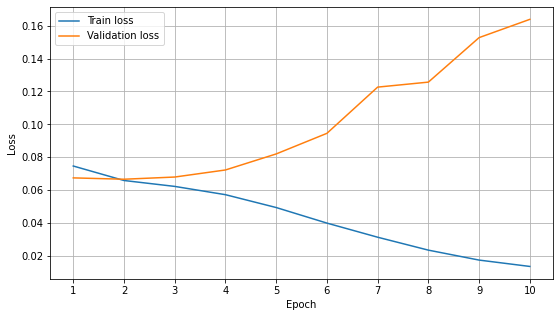

In [27]:
draw_plot(history)

Score model

In [0]:
test_loader = data.DataLoader(ExtDataset(ext_test_records, vocabulary, bpe_processor=bpe_processor), batch_size=1, collate_fn=collate_fn)

In [29]:
score_rnn_model(model, test_loader)

100%|██████████| 16000/16000 [02:33<00:00, 104.12it/s]


Count: 16000
Last true headline: в подмосковье грузовик врезался в легковушку: есть погибший
Last predicted headline: на дмитровском шоссе в подмосковье грузовой автомобиль выехал на встречную полосу, где врезался в легковой автомобиль.

BLEU:  0.17189417700095339
ROUGE:  
rouge-1:{'f': 0.13847848787757333, 'p': 0.11173363823403029, 'r': 0.21177665745712695}
rouge-2:{'f': 0.05215587367276837, 'p': 0.04231620110928426, 'r': 0.07807937808719001}
rouge-l:{'f': 0.12915742779499537, 'p': 0.10456762889533217, 'r': 0.19526992608086383} 

